<div class="alert alert-block alert-success">
    <b>Predicting User Adoption</b>
    <p>Defining an "adopted user" as a user who has logged into the product on three separate
       days in at least one seven­day period , identify which factors predict future user
       adoption .</p
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from datetime import datetime, timedelta
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [2]:
user_df = pd.read_csv("takehome_users.csv", encoding="latin-1")
user_eng_df = pd.read_csv("takehome_user_engagement.csv")

In [3]:
user_df

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [4]:
user_eng_df

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [5]:
user_df["creation_time"] = pd.to_datetime(user_df["creation_time"])

In [6]:
user_eng_df["time_stamp"] = pd.to_datetime(user_eng_df["time_stamp"])

In [7]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [8]:
user_df.describe().T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6.000500e+03,3.464246e+03,1.000000e+00,3.000750e+03,6.000500e+03,9.000250e+03,1.200000e+04
last_session_creation_time,8823.0,1.379279e+09,1.953116e+07,1.338452e+09,1.363195e+09,1.382888e+09,1.398443e+09,1.402067e+09
opted_in_to_mailing_list,12000.0,2.495000e-01,4.327417e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
enabled_for_marketing_drip,12000.0,1.493333e-01,3.564316e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
org_id,12000.0,1.418846e+02,1.240567e+02,0.000000e+00,2.900000e+01,1.080000e+02,2.382500e+02,4.160000e+02
invited_by_user_id,6417.0,5.962957e+03,3.383762e+03,3.000000e+00,3.058000e+03,5.954000e+03,8.817000e+03,1.199900e+04


In [9]:
user_eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [10]:
user_eng_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,207917.0,5913.314197,3394.941674,1.0,3087.0,5682.0,8944.0,12000.0
visited,207917.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [11]:
user_eng_df.user_id.nunique()

8823

In [12]:
user_df["last_session_creation_time"] = pd.to_datetime(user_df["last_session_creation_time"], unit="s")

In [13]:
user_df

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN


In [14]:
df= user_eng_df.copy()

In [15]:
df["date"] = pd.to_datetime(df["time_stamp"].dt.date)

In [16]:
df

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25
...,...,...,...,...
207912,2013-09-06 06:14:15,11996,1,2013-09-06
207913,2013-01-15 18:28:37,11997,1,2013-01-15
207914,2014-04-27 12:45:16,11998,1,2014-04-27
207915,2012-06-02 11:55:59,11999,1,2012-06-02


In [17]:
def rolling_count(df_group, frequency):
    return df_group.rolling(frequency, on="date")["user_id"].count()

In [18]:
df["visit_7_days"] = df.groupby("user_id", as_index=False, group_keys=False).apply(rolling_count, "7D")

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,207917.0,5913.314197,3394.941674,1.0,3087.0,5682.0,8944.0,12000.0
visited,207917.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
visit_7_days,207917.0,4.381393,2.042666,1.0,3.0,4.0,6.0,7.0


In [20]:
df[df["visit_7_days"] >=3]

,time_stamp,user_id,visited,date,visit_7_days
9,2014-02-09 03:45:04,2,1,2014-02-09,3.0
10,2014-02-13 03:45:04,2,1,2014-02-13,3.0
27,2013-02-19 22:08:03,10,1,2013-02-19,3.0
30,2013-03-02 22:08:03,10,1,2013-03-02,3.0
31,2013-03-05 22:08:03,10,1,2013-03-05,3.0
...,...,...,...,...,...
207898,2014-05-23 11:04:47,11988,1,2014-05-23,6.0
207899,2014-05-24 11:04:47,11988,1,2014-05-24,6.0
207900,2014-05-26 11:04:47,11988,1,2014-05-26,5.0
207901,2014-05-27 11:04:47,11988,1,2014-05-27,5.0


In [21]:
user_adopted = df.groupby("user_id")["visit_7_days"].max().reset_index()

In [22]:
user_adopted

,user_id,visit_7_days
0,1,1.0
1,2,3.0
2,3,1.0
3,4,1.0
4,5,1.0
...,...,...
8818,11996,1.0
8819,11997,1.0
8820,11998,1.0
8821,11999,1.0


In [23]:
user_adopted["adopted_user"] = user_adopted["visit_7_days"].map(lambda x: 1 if x>=3 else 0)

In [24]:
user_adopted

,user_id,visit_7_days,adopted_user
0,1,1.0,0
1,2,3.0,1
2,3,1.0,0
3,4,1.0,0
4,5,1.0,0
...,...,...,...
8818,11996,1.0,0
8819,11997,1.0,0
8820,11998,1.0,0
8821,11999,1.0,0


In [25]:
user_adopted.visit_7_days.value_counts()

1.0    6639
7.0     621
2.0     582
3.0     305
6.0     237
5.0     223
4.0     216
Name: visit_7_days, dtype: int64

In [26]:
user_adopted.drop("visit_7_days", axis=1, inplace=True)
user_adopted.rename(columns={"user_id":"object_id"}, inplace=True)

In [27]:
user_adopted

,object_id,adopted_user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
...,...,...
8818,11996,0
8819,11997,0
8820,11998,0
8821,11999,0


In [28]:
user_adopted.set_index("object_id", inplace=True)

In [29]:
user_adopted

,adopted_user
object_id,
1,0
2,1
3,0
4,0
5,0
...,...
11996,0
11997,0
11998,0


In [30]:
df_users = user_df.join(user_adopted, on="object_id", how="left")

In [31]:
df_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0.0


In [32]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted_user                8823 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


In [33]:
df_users["last_session_creation_time"].fillna(0, inplace=True)
df_users["adopted_user"].fillna(0, inplace=True)
df_users["invited_by_user_id"].fillna(0, inplace=True)

In [34]:
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6000.500000,3464.245950,1.0,3000.75,6000.5,9000.25,12000.0
opted_in_to_mailing_list,12000.0,0.249500,0.432742,0.0,0.00,0.0,0.00,1.0
enabled_for_marketing_drip,12000.0,0.149333,0.356432,0.0,0.00,0.0,0.00,1.0
org_id,12000.0,141.884583,124.056723,0.0,29.00,108.0,238.25,416.0
invited_by_user_id,12000.0,3188.691333,3869.027693,0.0,0.00,875.0,6317.00,11999.0
adopted_user,12000.0,0.133500,0.340128,0.0,0.00,0.0,0.00,1.0


In [35]:
df_users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0


In [36]:
df_users["email_domain"] = df_users["email"].map(lambda x: x.split("@")[1])

In [37]:
df_users["email_domain"].value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
                  ... 
lrabg.com            1
mrytw.com            1
ugtav.com            1
hqhll.com            1
iuxiw.com            1
Name: email_domain, Length: 1184, dtype: int64

<div class="alert alert-block alert-success">
    <p>Lets drop the email column since there are too many fake email ids</p>

In [38]:
df_users.drop(["object_id","name", "email", "email_domain"], axis=1, inplace=True)

In [39]:
df_users["days_since_creation"] = (user_eng_df["time_stamp"].max()- pd.to_datetime(df_users["creation_time"])).dt.days

In [40]:
df_users

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,days_since_creation
0,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,45
1,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,203
2,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,443
3,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0,381
4,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0,505
...,...,...,...,...,...,...,...,...,...
11995,2013-09-06 06:14:15,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0.0,273
11996,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,0.0,0.0,511
11997,2014-04-27 12:45:16,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0.0,40
11998,2012-05-31 11:55:59,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,0.0,0.0,736


In [41]:
df_users.drop(["last_session_creation_time", "creation_time"], axis=1, inplace=True)

In [42]:
df_users = pd.get_dummies(df_users, columns=["creation_source"])

In [43]:
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
opted_in_to_mailing_list,12000.0,0.249500,0.432742,0.0,0.0,0.0,0.00,1.0
enabled_for_marketing_drip,12000.0,0.149333,0.356432,0.0,0.0,0.0,0.00,1.0
org_id,12000.0,141.884583,124.056723,0.0,29.0,108.0,238.25,416.0
invited_by_user_id,12000.0,3188.691333,3869.027693,0.0,0.0,875.0,6317.00,11999.0
adopted_user,12000.0,0.133500,0.340128,0.0,0.0,0.0,0.00,1.0
days_since_creation,12000.0,324.568000,216.646173,6.0,129.0,304.0,506.00,736.0
creation_source_GUEST_INVITE,12000.0,0.180250,0.384412,0.0,0.0,0.0,0.00,1.0
creation_source_ORG_INVITE,12000.0,0.354500,0.478381,0.0,0.0,0.0,1.00,1.0
creation_source_PERSONAL_PROJECTS,12000.0,0.175917,0.380765,0.0,0.0,0.0,0.00,1.0
creation_source_SIGNUP,12000.0,0.173917,0.379054,0.0,0.0,0.0,0.00,1.0


In [44]:
df_users.isnull().sum()

opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
org_id                                0
invited_by_user_id                    0
adopted_user                          0
days_since_creation                   0
creation_source_GUEST_INVITE          0
creation_source_ORG_INVITE            0
creation_source_PERSONAL_PROJECTS     0
creation_source_SIGNUP                0
creation_source_SIGNUP_GOOGLE_AUTH    0
dtype: int64

In [45]:
df_users.corr()["adopted_user"]

opted_in_to_mailing_list              0.008097
enabled_for_marketing_drip            0.004653
org_id                                0.064523
invited_by_user_id                    0.021596
adopted_user                          1.000000
days_since_creation                   0.088020
creation_source_GUEST_INVITE          0.045408
creation_source_ORG_INVITE           -0.007636
creation_source_PERSONAL_PROJECTS    -0.075817
creation_source_SIGNUP                0.009299
creation_source_SIGNUP_GOOGLE_AUTH    0.036119
Name: adopted_user, dtype: float64

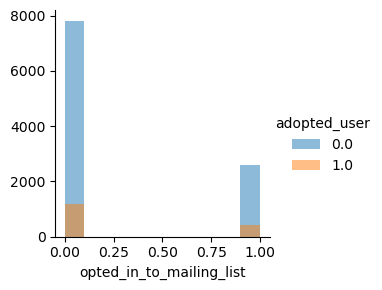

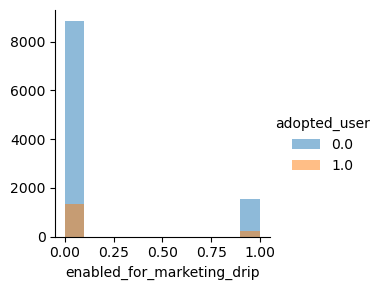

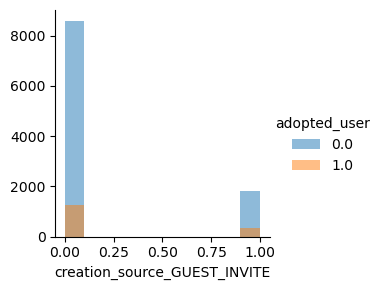

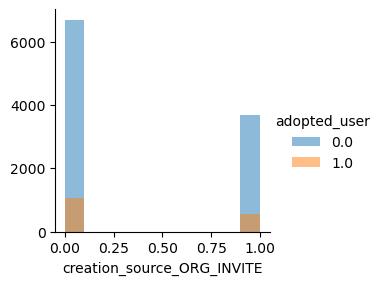

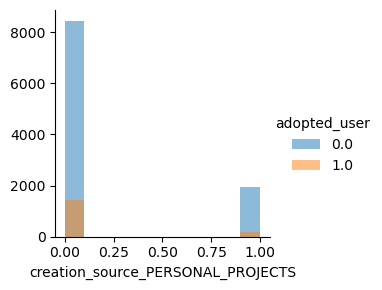

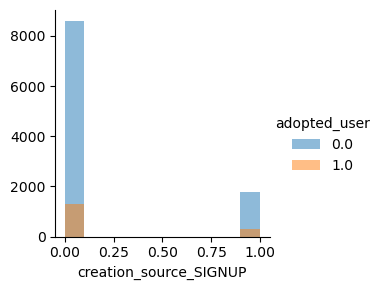

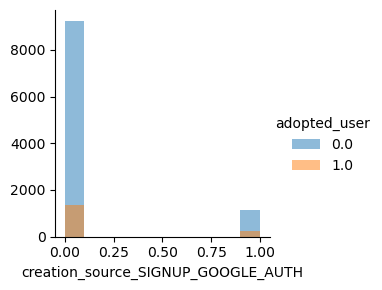

In [46]:
for col in ["opted_in_to_mailing_list", "enabled_for_marketing_drip",
           "creation_source_GUEST_INVITE", "creation_source_ORG_INVITE", "creation_source_PERSONAL_PROJECTS", 
           "creation_source_SIGNUP", "creation_source_SIGNUP_GOOGLE_AUTH"]:
    g = sns.FacetGrid(df_users, hue="adopted_user")
    g.map(plt.hist, col, alpha=0.5)
    g.add_legend()

In [47]:
df_users["adopted_user"].value_counts(normalize=True)

0.0    0.8665
1.0    0.1335
Name: adopted_user, dtype: float64

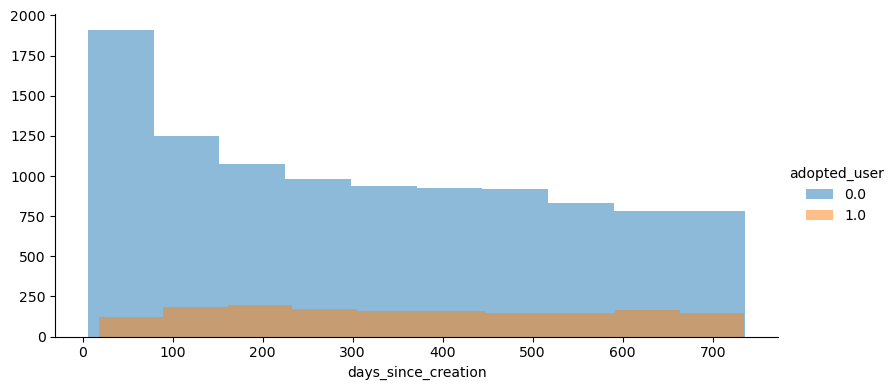

In [48]:
g = sns.FacetGrid(df_users, hue="adopted_user", height=4, aspect=2)
g.map(plt.hist, "days_since_creation", alpha=0.5)
g.add_legend()

<div class="alert alert-block alert-success">
    <p> We can see that only 13.35% of the users are adopted so the class pretty unbalanced</p>
    <b> Lets try modeling Random Forest Classifier, and since we are using trees, there is no need to scale the features</b>

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score\
, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
import time

In [50]:
def cv_optimize(model, params, X_train, y_train, n_folds=5):
    gcv = GridSearchCV(model, param_grid=params, cv=n_folds, scoring="accuracy")
    t0 = time.time()
    gcv.fit(X_train, y_train)
    time_fit = time.time() - t0
    
    print(f"========== {type(model).__name__} ============")
    print(f"It takes {time_fit} to tune the model")
    print("BEST PARAMS", gcv.best_params_)
    
    best_model = gcv.best_estimator_
    return best_model

In [51]:
def classify(model, params, df, targetname, scale=True, featurenames="all", train_size=0.8):
    if featurenames=="all":
        X = df.drop([targetname], axis=1)
    else:
        X = df[featurenames]
    
    y = df[targetname]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    gcv_model = cv_optimize(model, params, X_train, y_train)
    rf_model = gcv_model.fit(X_train, y_train)
    
    training_accuracy = rf_model.score(X_train, y_train)
    test_accuracy = rf_model.score(X_test, y_test)
    
    precision = precision_score(y_test, rf_model.predict(X_test))
    recall = recall_score(y_test, rf_model.predict(X_test))
    
    AUC = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
    
    
    print("Accuracy on training set {:.2f}".format(training_accuracy))
    print("Accuracy on test set {:.2f}".format(test_accuracy))
    print("Precision Score on test set {:.2f}".format(precision))
    print("Recall Score on test set {:.2f}".format(recall))
    print("AUC Score on test set {:.2f}".format(AUC))
    print("======== Confusion Matrix ==========")
    print(confusion_matrix(y_test, rf_model.predict(X_test)))
    
    print("========== Classification Report ============")
    print(classification_report(y_test, rf_model.predict(X_test)))
    
    print("="*50)
    
    print("="*50)
    
    return rf_model, X_train, X_test, y_train, y_test
    
    

In [52]:
#Random Forest Model
rf_model = RandomForestClassifier(class_weight="balanced")
params = {"n_estimators":[10, 25, 50, 75, 100],
         "criterion":["gini", "entropy"],
         "max_depth":[3, 6, 8, 10, 12],
         "max_features":["auto", "sqrt"]}

In [53]:
model_rf, X_train, X_test, y_train, y_test = classify(rf_model, params=params, targetname="adopted_user", df=df_users)

========== RandomForestClassifier ============
It takes 74.38801097869873 to tune the model
BEST PARAMS {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100}
Accuracy on training set 0.81
Accuracy on test set 0.71
Precision Score on test set 0.21
Recall Score on test set 0.41
AUC Score on test set 0.64
======== Confusion Matrix ==========
[[1557  508]
 [ 196  139]]
========== Classification Report ============
              precision    recall  f1-score   support

         0.0       0.89      0.75      0.82      2065
         1.0       0.21      0.41      0.28       335

    accuracy                           0.71      2400
   macro avg       0.55      0.58      0.55      2400
weighted avg       0.79      0.71      0.74      2400



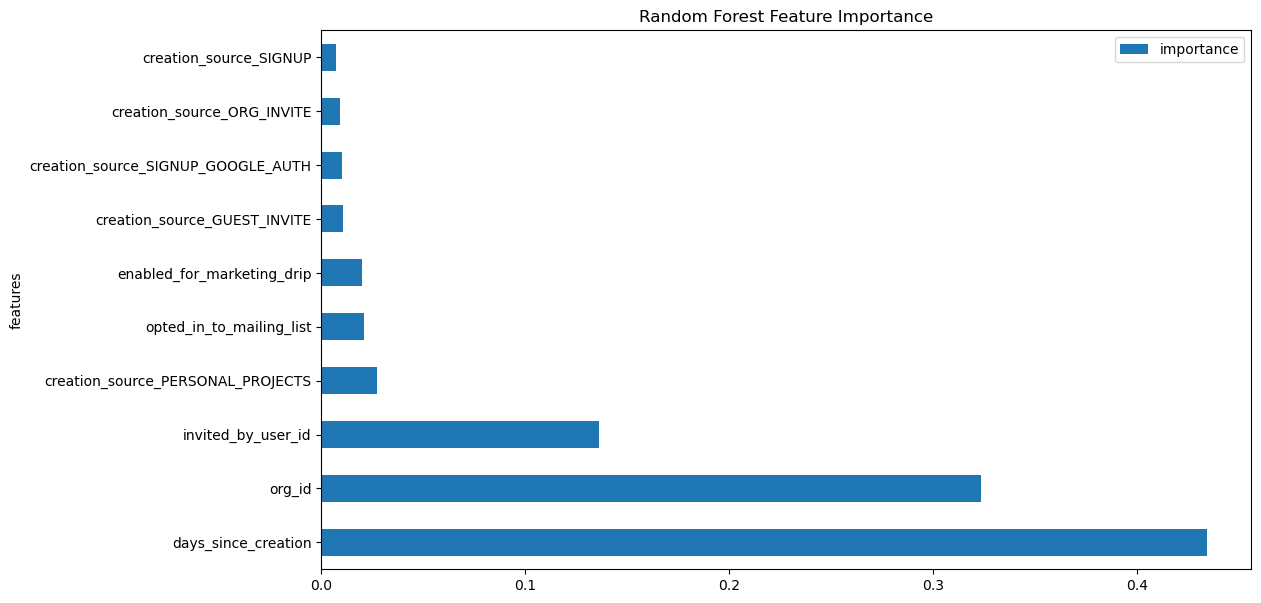

In [54]:
feat_imp = pd.DataFrame({"importance":model_rf.feature_importances_})
feat_imp["features"] = X_train.columns

feat_imp.sort_values(by="importance", ascending=False, inplace=True)
feat_imp.set_index("features", inplace=True)
_ = feat_imp.plot.barh(title="Random Forest Feature Importance", figsize=(12, 7))